In [1]:
## Preloads
using Statistics
using FFTW
using Distributed
using Plots
using BenchmarkTools
using Profile
using LinearAlgebra
using Measures
using HDF5
using Plots
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
using DHC_2DUtils
using MLDatasets
using Images
using HDF5
theme(:dark)

Playing with phase ReLU

In [2]:
# generate an image of a rod with some position, length, position angle,
# and FWHM
function rod(xcen, ycen, length, pa, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    dtor = pi/180
    # -------- define a unit vector in direction of rod at position angle pa
    ux = sin(pa*dtor)   #  0 deg is up
    uy = cos(pa*dtor)   # 90 deg to the right

    # -------- distance parallel and perpendicular to 
    dpara =  ux.*sx + uy.*sy
    dperp = -uy.*sx + ux.*sy
    
    dpara[abs.(dpara).-length .<0] .= 0
    dpara = abs.(dpara)
    dpara .= min.(abs.(dpara.-length),dpara)
    
    rodimage = exp.(-(dperp.^2+dpara.^2)./(2*sig.^2))

    return rodimage
end

rod (generic function with 1 method)

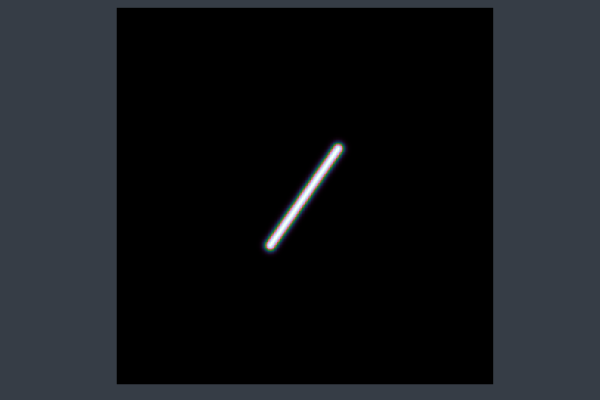

In [3]:
Plots.plot(Plots.heatmap(
    rod(0,0,40,35,6),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

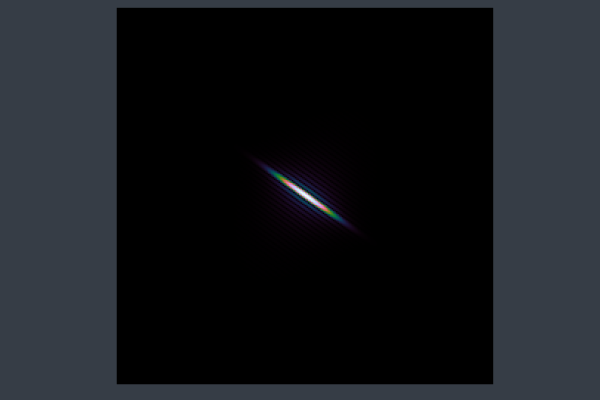

In [7]:
Plots.plot(Plots.heatmap(
    fftshift(abs.(fft(rod(0,0,40,35,6)))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

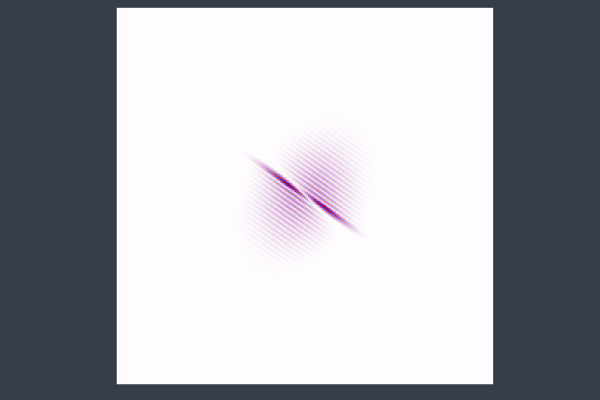

In [10]:
Plots.plot(Plots.heatmap(
    fftshift(imag.(fft(rod(0,0,40,35,6)))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    legend = :none,
    margin=0mm))

In [21]:
minimum(fftshift(real.(fft(fftshift(rod(0,0,40,35,6)))))),maximum(fftshift(real.(fft(fftshift(rod(0,0,40,35,6))))))

(-116.44220642066966, 551.689993393154)

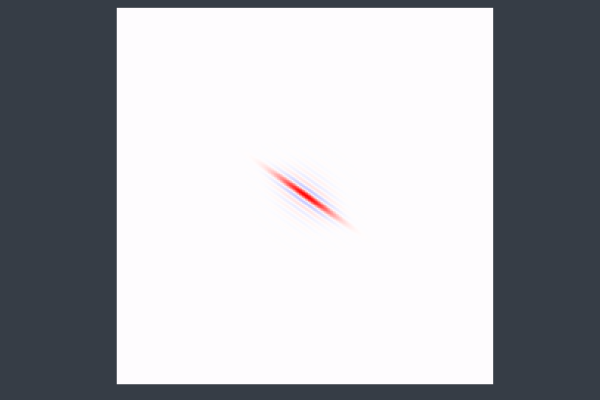

In [22]:
Plots.plot(Plots.heatmap(
    fftshift(real.(fft(fftshift(rod(0,0,40,35,6))))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    clims=(-551.689993393154,551.689993393154),
    legend = :none,
    margin=0mm))

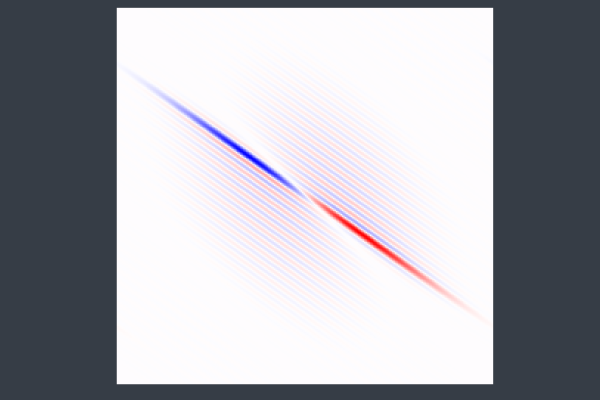

In [16]:
Plots.plot(Plots.heatmap(
    fftshift(imag.(fft(fftshift(rod(0,0,40,35,2))))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    legend = :none,
    margin=0mm))

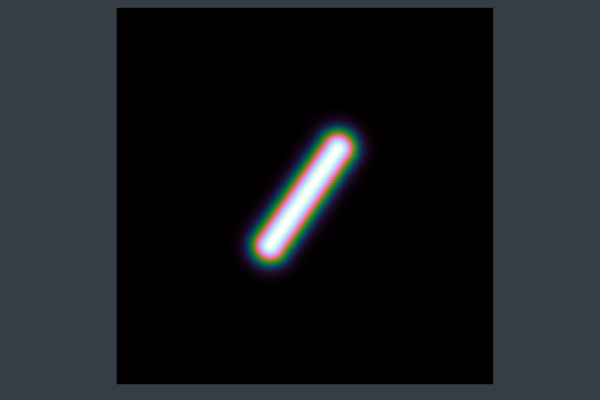

In [58]:
Plots.plot(Plots.heatmap(
    rod(0,0,40,35,20),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

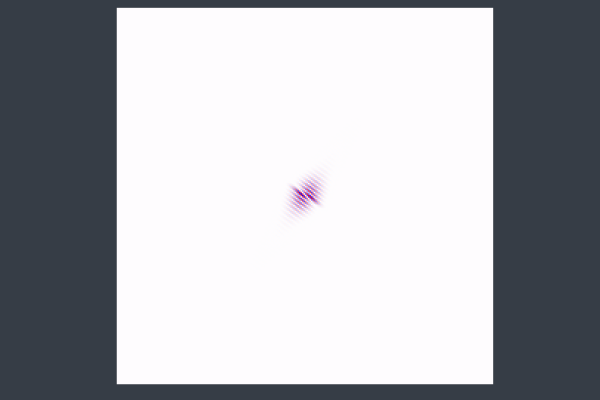

In [59]:
Plots.plot(Plots.heatmap(
    fftshift(imag.(fft(rod(0,0,40,35,20)))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    legend = :none,
    margin=0mm))

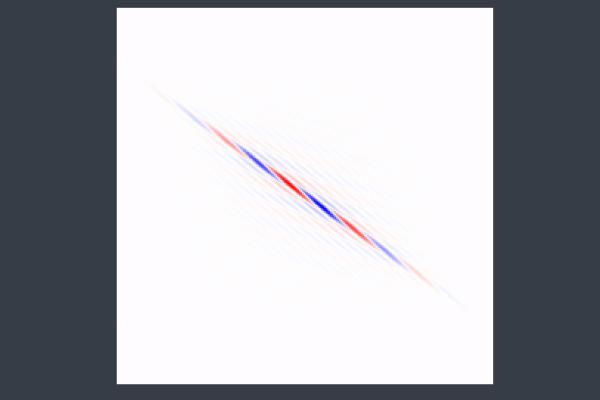

In [26]:
Plots.plot(Plots.heatmap(
    fftshift(imag.(fft(circshift(fftshift(rod(0,0,40,35,2)),[20,20])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    legend = :none,
    margin=0mm))

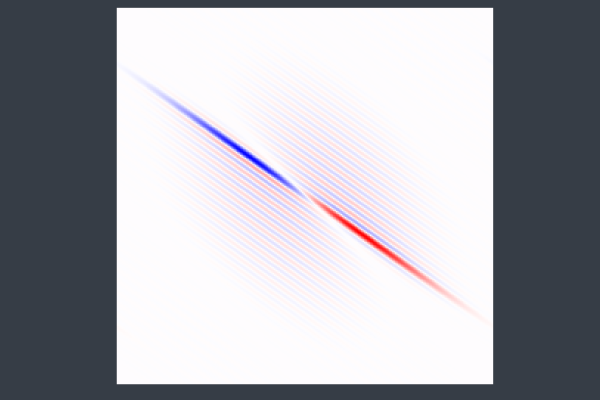

In [158]:
shiftx = 128
shifty = 128
Plots.plot(Plots.heatmap(
    fftshift(imag.(exp.(-2*π*im*(shiftx.*fsx.+shifty.*fsy)).*fft(circshift(fftshift(rod(0,0,40,35,2)),[-shifty,-shifty])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    legend = :none,
    margin=0mm))

In [31]:
shift_mat = zeros(256,256)
temp = zeros(256,256)
@inbounds @simd for i=1:256
    for j=1:256
        temp = fftshift(imag.(fft(circshift(fftshift(rod(0,0,40,35,2)),[j,i]))))
        temp[temp.<0] .= 0
        temp .= temp.^2
        shift_mat[j,i] = sum(temp)
    end
end

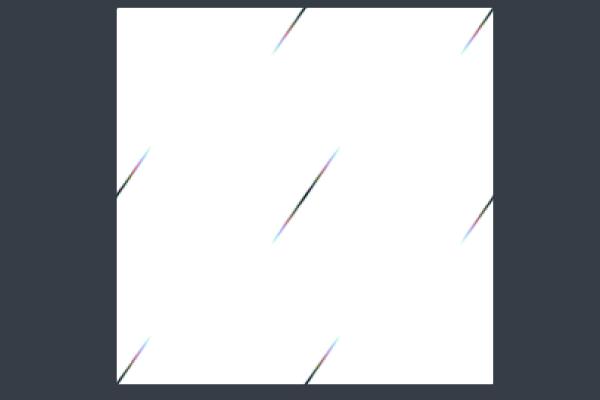

In [51]:
Plots.plot(Plots.heatmap(
    shift_mat,
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    #clims=(1,5),
    legend = :none,
    margin=0mm))

In [21]:
function circle_a(xcen, ycen, length, pa, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    
    r = sqrt.(sx.^2 + sy.^2)
    
    r[r.-length.<0] .= 0
    r .= min.(abs.(r.-length),r)

    rodimage = exp.(-(r.^2)./(2*sig.^2))

    return rodimage
end

circle_a (generic function with 1 method)

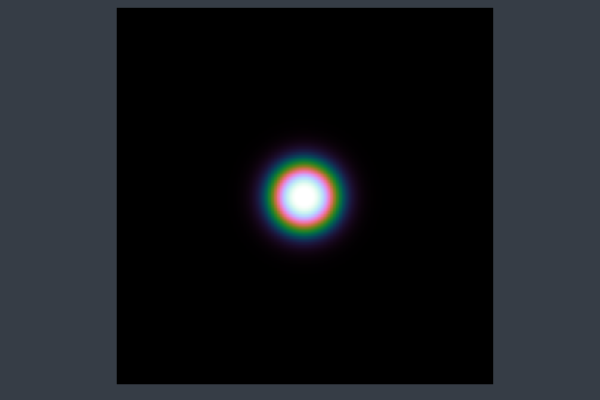

In [28]:
Plots.plot(Plots.heatmap(
    circle_a(0,0,5,0,30),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

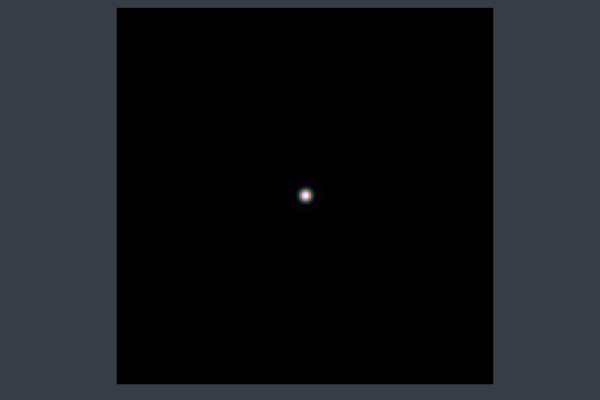

In [29]:
Plots.plot(Plots.heatmap(
    fftshift(abs.(fft(circle_a(0,0,5,0,30)))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

LoadError: UndefVarError: vPlots not defined

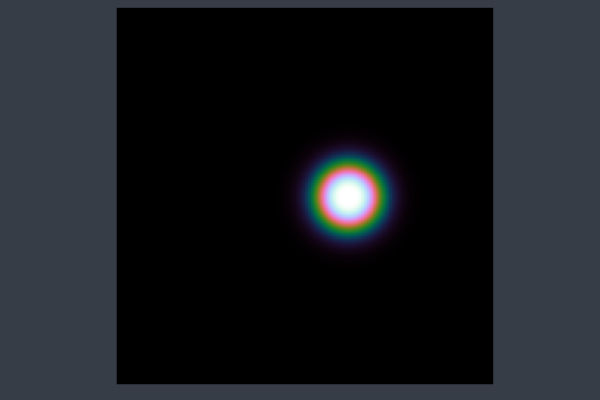

In [34]:
Plots.plot(Plots.heatmap(
    circshift(circle_a(0,0,5,0,30),[0,30]),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

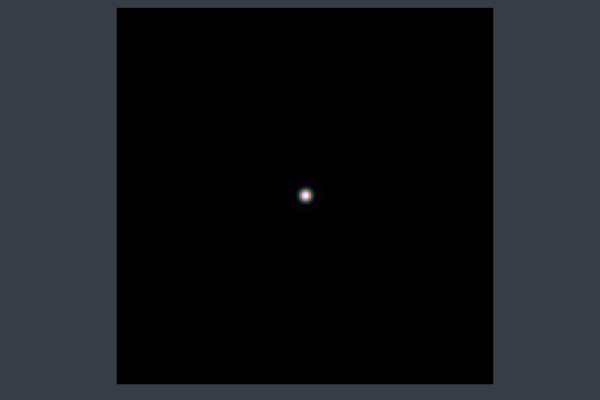

In [35]:
Plots.plot(Plots.heatmap(
    fftshift(abs.(fft(circshift(circle_a(0,0,5,0,30),[20,20])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

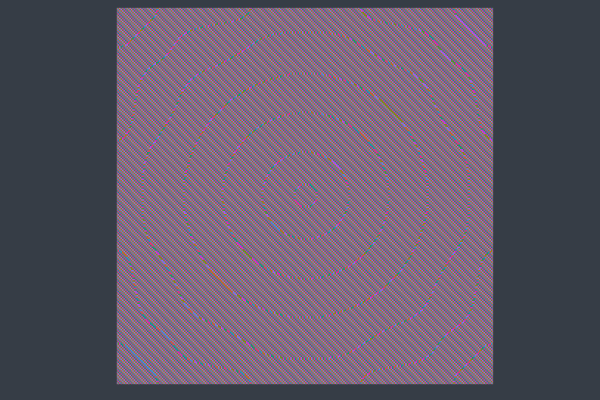

In [37]:
Plots.plot(Plots.heatmap(
    fftshift(angle.(fft(circshift(circle_a(0,0,5,0,30),[20,20])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:phase,
    clims=(-π,π),
    legend = :none,
    margin=0mm))

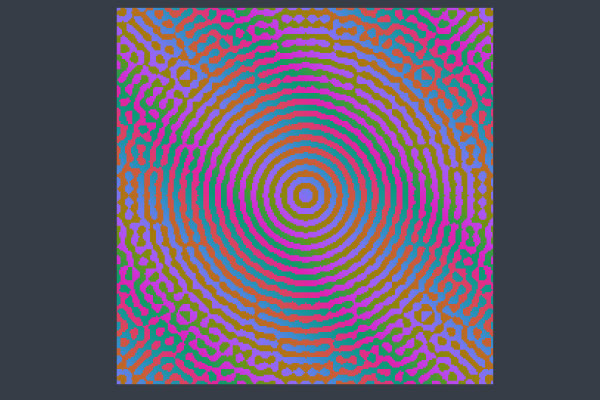

In [138]:
Plots.plot(Plots.heatmap(
    fftshift(angle.(fft(circshift(circle_a(0,0,32,0,.01),[128,128])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:phase,
    clims=(-π,π),
    legend = :none,
    margin=0mm))

(256, 256)

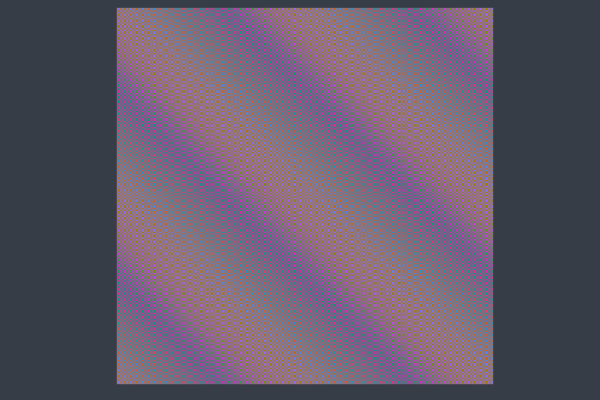

In [107]:
temp = zeros(256,256)
temp[128-32:128+32,128-32:128+32].=1
Plots.plot(Plots.heatmap(
    fftshift(angle.(fft(circshift(temp,[0,0])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:phase,
    clims=(-π,π),
    legend = :none,
    margin=0mm))

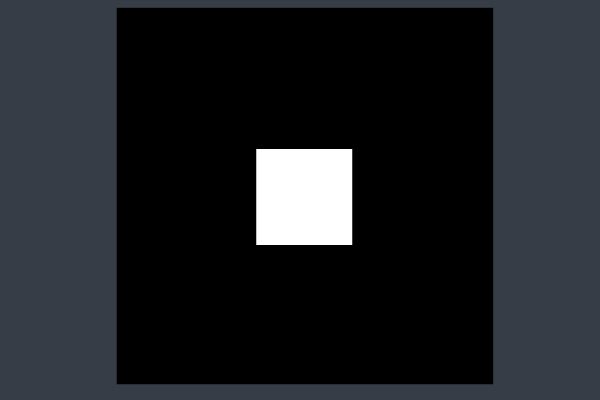

In [108]:
Plots.plot(Plots.heatmap(
    temp,
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

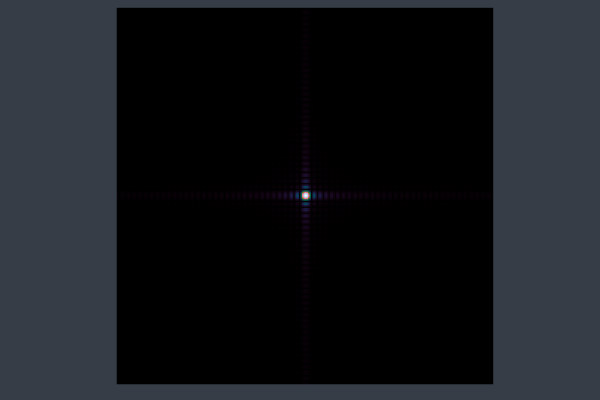

In [110]:
Plots.plot(Plots.heatmap(
    fftshift(abs.(fft(temp))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

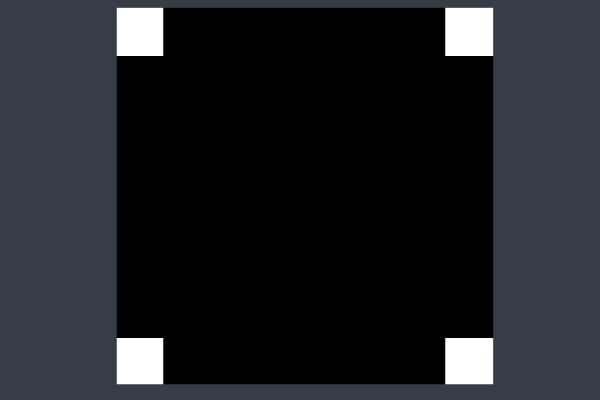

In [112]:
Plots.plot(Plots.heatmap(
    circshift(temp,[128,128]),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

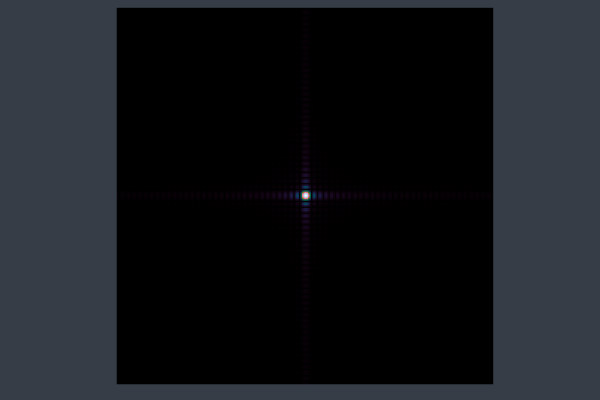

In [116]:
Plots.plot(Plots.heatmap(
    fftshift(abs.(fft(circshift(temp,[128,128])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

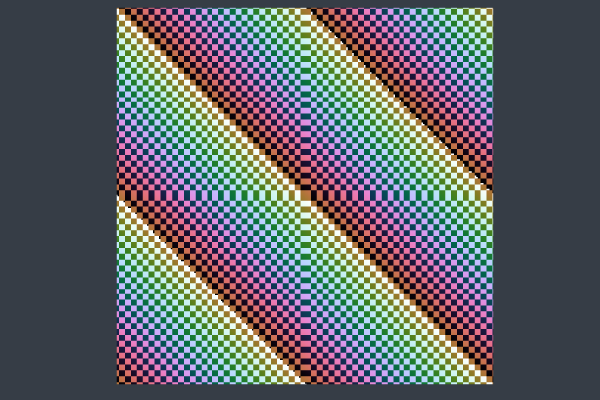

In [117]:
Plots.plot(Plots.heatmap(
    fftshift(angle.(fft(circshift(temp,[128,128])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

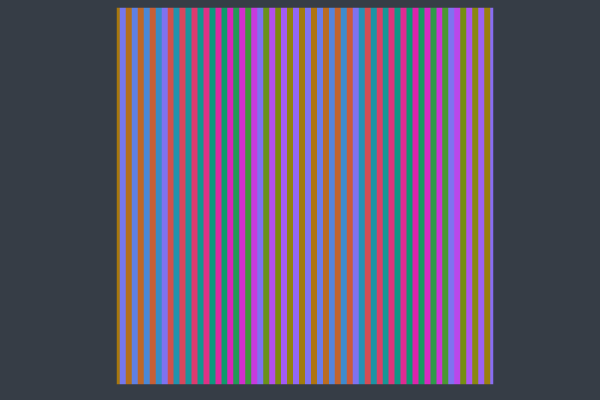

In [132]:
temp = zeros(64,64)
temp[1,32+2]=1
temp[1,32-2]=1
Plots.plot(Plots.heatmap(
    fftshift(angle.(fft(circshift(temp,[0,0])))),
    xlims=(1,64),
    ylims=(1,64),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:phase,
    clims=(-π,π),
    legend = :none,
    margin=0mm))

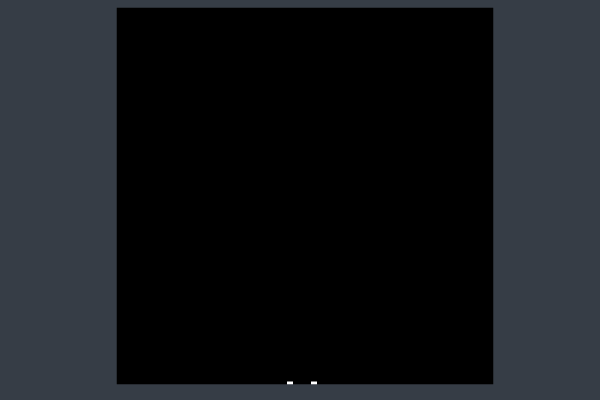

In [133]:
Plots.plot(Plots.heatmap(
    temp,
    xlims=(1,64),
    ylims=(1,64),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [48]:
function gaussian(xcen, ycen, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    
    r = sqrt.(sx.^2 + sy.^2)

    rodimage = exp.(-(r.^2)./(2*sig.^2))

    return rodimage
end

gaussian (generic function with 2 methods)

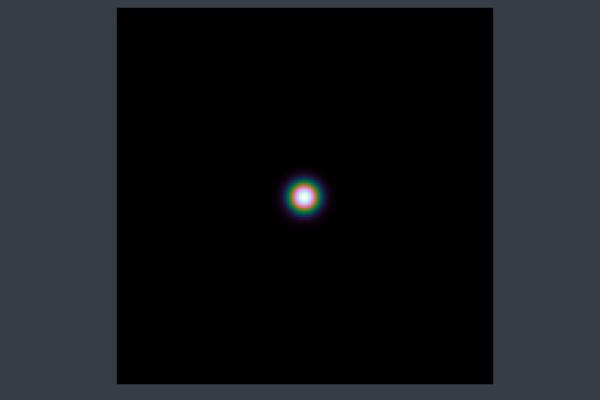

In [69]:
Plots.plot(Plots.heatmap(
    gaussian(0, 0, 16),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

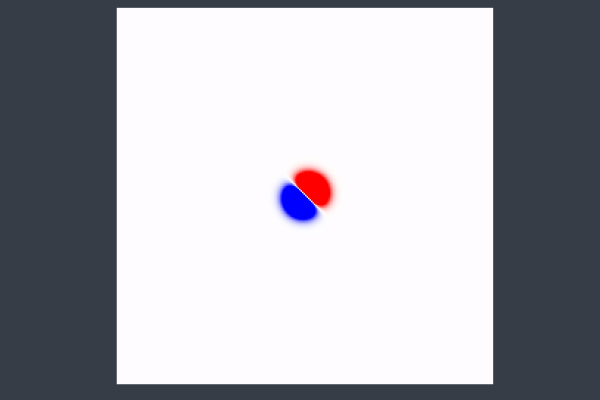

In [156]:
nx = 256
xbox = 1:nx
ybox = 1:nx
xbox = xbox.-nx/2
ybox = ybox.-nx/2

sx  = xbox' .* ones(size(ybox)[1])
sy  = ones(size(xbox)[1])' .* ybox

fsx = fftshift(fftfreq(256,1))' .* ones(size(ybox)[1])
fsy = ones(size(ybox)[1])' .* fftshift(fftfreq(256,1))

shiftx = 20
Plots.plot(Plots.heatmap(
    fftshift(imag.(exp.(-2*π*im*shiftx.*fsx).*fft(circshift(gaussian(0, 0, 16),[128,128-shiftx])))),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:bwr,
    clims=(-π,π),
    legend = :none,
    margin=0mm))

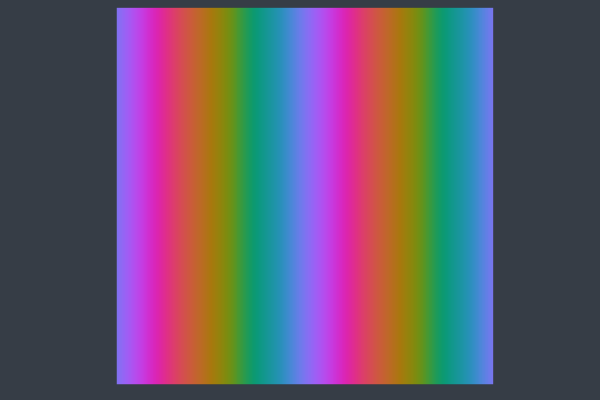

In [144]:
shiftx = 2
Plots.plot(Plots.heatmap(
    angle.(exp.(-2*π*im*shiftx.*fsx)),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:phase,
    legend = :none,
    margin=0mm))

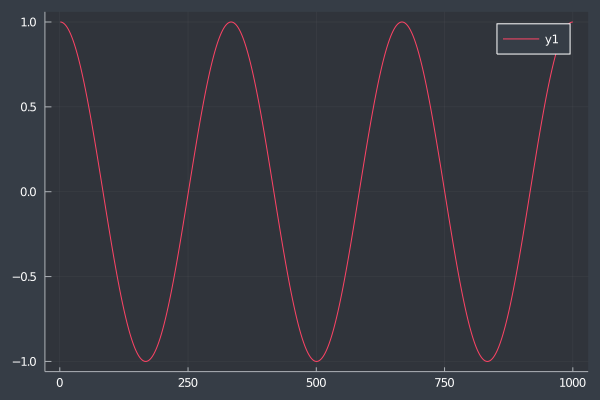

In [133]:
Plots.plot(real.(exp.(-2*π*im.*range(0,stop=3,length=1000))))

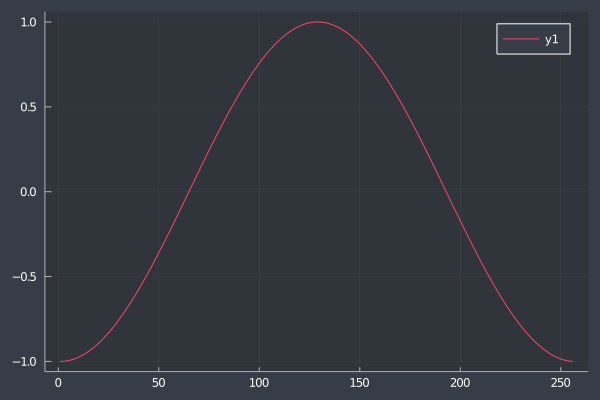

In [140]:
Plots.plot(real.(exp.(-2*π*im.*fftshift(fftfreq(256,1)))))